In [1]:
%matplotlib inline

In [2]:
import numpy as np
from vtk_rw import read_vtk
from sklearn import linear_model
import scipy.stats as stats
import pickle
import matplotlib.pyplot as plt
import itertools
import pandas as pd

### prepare data

In [3]:
rh_mesh_file='/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/inflated/rh_lowres_new_infl50.vtk'
lh_mesh_file='/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/inflated/lh_lowres_new_infl50.vtk'
full_mask_file='/scr/ilz3/myelinconnect/new_groupavg/masks/fullmask_lh_rh_new.npy'
rh_t1_file='/scr/ilz3/myelinconnect/new_groupavg/t1/smooth_3/rh_t1_avg_smooth_3.npy'
lh_t1_file='/scr/ilz3/myelinconnect/new_groupavg/t1/smooth_3/lh_t1_avg_smooth_3.npy'
embed_file='/scr/ilz3/myelinconnect/new_groupavg/embed/both_smooth_3_embed.npy'
embed_dict_file='/scr/ilz3/myelinconnect/new_groupavg/embed/both_smooth_3_embed_dict.pkl'

In [92]:
lv,_,_ = read_vtk(lh_mesh_file)
lh_t1 = np.load(lh_t1_file)
rv,_,_ = read_vtk(rh_mesh_file)
rh_t1 = np.load(rh_t1_file)

mask = np.load(full_mask_file)

# prepare embedding (normalized from entry in dict)
pkl_in = open(embed_dict_file, 'r')
embed_dict=pickle.load(pkl_in)
pkl_in.close()

embed_masked = np.zeros((embed_dict['vectors'].shape[0], embed_dict['vectors'].shape[1]-1))
for comp in range(100):
    embed_masked[:,comp]=(embed_dict['vectors'][:,comp+1]/embed_dict['vectors'][:,0])
    #embed_masked /= np.linalg.norm(embed_masked, axis=0)

# unmask the embedding, that has been saved in masked form
idcs=np.arange(0,(lv.shape[0]+rv.shape[0]))
nonmask=np.delete(idcs, mask)
embed = np.zeros(((lv.shape[0]+rv.shape[0]),100))
embed[nonmask] = embed_masked

# extend mask to nodes that have a t1avg < 1500
full_t1 = np.concatenate((lh_t1, rh_t1))
fullmask = np.unique(np.concatenate((mask,np.where(full_t1<=1500)[0])))
fullmask = np.asarray(fullmask, dtype='int64')
nonmask_bigmask=np.delete(idcs, fullmask)

# mask embedding and t1
masked_t1 = np.delete(full_t1, fullmask)
masked_embed = np.delete(embed, fullmask, axis=0)

# normalize vectors to norm 1 (so that BIC derivation works)
masked_embed /= np.linalg.norm(masked_embed, axis=0)
masked_t1 /= np.linalg.norm(masked_t1, axis=0)

### run single model

In [93]:
maps = range(10)

In [94]:
clf = linear_model.LinearRegression()
clf.fit(masked_embed[:,maps], masked_t1)

modelled_fit = clf.predict(masked_embed[:,maps])
residuals = masked_t1 - clf.predict(masked_embed[:,maps])

In [95]:
print clf.score(masked_embed[:,maps], masked_t1)
print clf.coef_

0.62172677432
[-0.03592487  0.01281974  0.00231125  0.00203072 -0.01735593 -0.02114851
 -0.0148418   0.00568999  0.01135257 -0.01313917]


### calculate BIC for model

In [96]:
def BIC(params, residuals):
    '''
    parameters : free parameters to the model
    residuals : residuals resulting from predicting the actual data using the model with parameters p (not squared)
    '''
    # infer number of free parameters and sample points
    p = params.shape[0]
    n = residuals.shape[0]
    
    # estimate for parameter and residual variance, both assumed to be Gaussian distributed
    sigma2_p = (1./p) * np.sum(params**2)
    sigma2_res = (1./n) * np.sum(residuals**2)
    
    # approximation for bic through taylor expansion around optimal parameters
    bic = 1 + p + p * np.log(1+(sigma2_p/sigma2_res)) #+ np.log(2*np.pi*sigma2_res)
    
    return bic

In [98]:
BIC(clf.coef_, residuals)

109.92837775158164

### iterate over all possible models

In [99]:
maps = range(10)
combinations = []

for i in range(len(maps)):
    element = [list(x) for x in itertools.combinations(maps, i+1)]
    combinations.extend(element)

In [100]:
len(combinations)

1023

In [101]:
df = pd.DataFrame(columns=["Maps", "Pearson's r", "R squared", "BIC"], index=range(len(combinations)))

In [102]:
for c in range(len(combinations)):
    maps=combinations[c]
    clf = linear_model.LinearRegression()
    clf.fit(masked_embed[:,maps], masked_t1)

    modelled_fit = clf.predict(masked_embed[:,maps])
    residuals = masked_t1 - clf.predict(masked_embed[:,maps])
    
    df["Maps"][c] = tuple(maps)
    df["Pearson's r"][c] = stats.pearsonr(modelled_fit, masked_t1)
    df["R squared"][c] = clf.score(masked_embed[:,maps], masked_t1)
    df["BIC"][c] = BIC(clf.coef_, residuals)

In [111]:
df.iloc[np.where(df['BIC']>80)]

,Maps,Pearson's r,R squared,BIC
967,"(0, 1, 2, 3, 4, 5, 6, 7)","(0.744381634757, 0.0)",0.554104,87.69841
968,"(0, 1, 2, 3, 4, 5, 6, 8)","(0.758754233113, 0.0)",0.575708,88.40385
969,"(0, 1, 2, 3, 4, 5, 6, 9)","(0.765191746935, 0.0)",0.5855184,88.72294
970,"(0, 1, 2, 3, 4, 5, 7, 8)","(0.730458652025, 0.0)",0.5335698,87.01511
971,"(0, 1, 2, 3, 4, 5, 7, 9)","(0.737254960237, 0.0)",0.5435449,87.33559
972,"(0, 1, 2, 3, 4, 5, 8, 9)","(0.751652139435, 0.0)",0.5649809,88.03047
973,"(0, 1, 2, 3, 4, 6, 7, 8)","(0.694676824703, 0.0)",0.4825759,85.4363
974,"(0, 1, 2, 3, 4, 6, 7, 9)","(0.701955794978, 0.0)",0.4927419,85.76297
975,"(0, 1, 2, 3, 4, 6, 8, 9)","(0.717053192948, 0.0)",0.5141653,86.44683
976,"(0, 1, 2, 3, 4, 7, 8, 9)","(0.686950767382, 0.0)",0.4719014,85.06785


In [90]:
df.iloc[np.argmin(df["BIC"])]

Maps                                           (3,)
Pearson's r    (0.0290484147859, 6.11279139765e-24)
R squared                              0.0008438104
BIC                                        18.24924
Name: 3, dtype: object

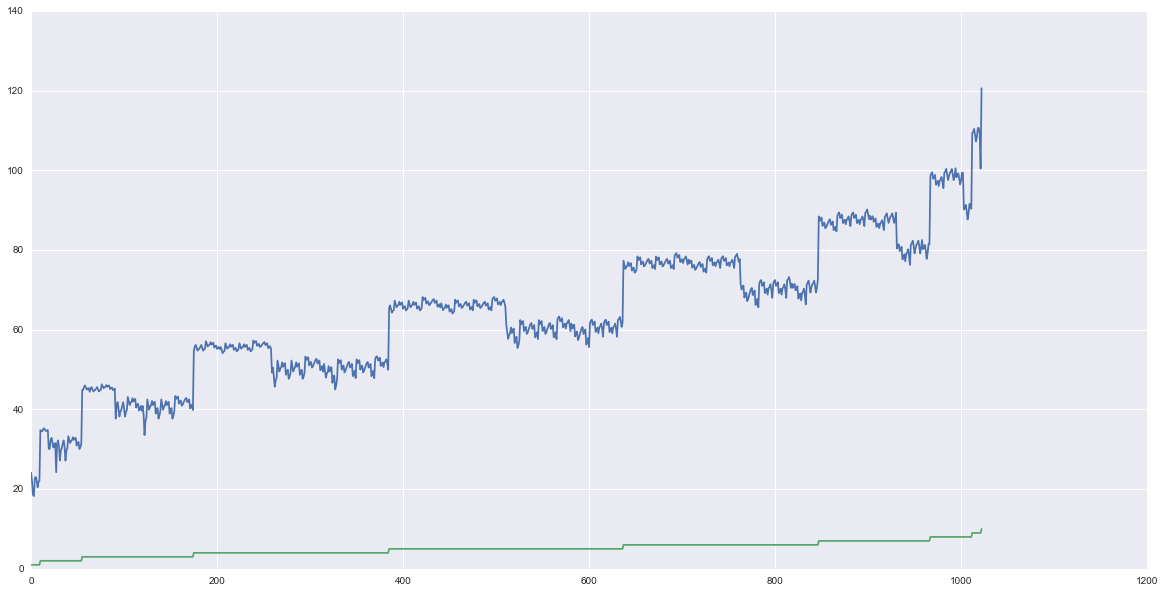

In [91]:
import seaborn as sns
fig = plt.figure(figsize=(20,10))
plt.plot(df["BIC"])
plt.plot([len(df['Maps'][i]) for i in range(len(df['Maps']))])

### Schwartz weights

schwartz[i] can be interpreted as the probability that i is the best model ( in the BIC sense, ie the true generating model is beyond the candidate models, hence schwartz[i] is the probability for i to be the true generating model)

In [51]:
def Schwartz(bic_all):
    
    best = bic_all[np.argmin(bic_all)]
    schwartz = []
    
    for model in bic_all:
        bic_diff = model - best
        schwartz.append(np.exp(-bic_diff/2.))
    
    schwartz = schwartz / np.sum(schwartz)
    
    return schwartz
    

### Evidence ration of Schwartz weights
expressing how many times more likely model i is than model j
resp. normalized probability that i is preferred over j